# **Setup**



In [81]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(tf.__version__)
tf.enable_eager_execution()

1.15.0


# **Load data**

In [82]:
data_url= "https://docs.google.com/spreadsheets/d/e/2PACX-1vR3Pmapy-1Q0D0XaIlZKNIEKNw0h0zn41V0EvQwW8ULJtR33GFyRt82hrkfigZw-x64A8AgJOsTbDbS/pub?gid=0&single=true&output=csv"
data = pd.read_csv(data_url)
data.head()

,name,score,ingredients
0,White & Elm Exfoliating Enzyme Mask,1,"Aqua (Distilled Water), Carica Papaya (Papaya)..."
1,Inna Organic Rose Geranium Skin Soothing Facia...,1,"Demineralized Water, Butylene Glycol, Propaned..."
2,C'est Moi Soothing Aloe and Cucumber Facial Mask,1,"Aqua/Water/Eau, Glycerin, Aloe Barbadensis Lea..."
3,Knours. Sweet Enough Rescue Mask,1,"Water, Rosa Centifolia Flower Water, Propanedi..."
4,Aromatica Sea Daffodil Hydro Charge Mask,1,"Aqua, Aloe barbadensis leaf extract, Glycerin,..."


# **Exploring data**

In [83]:
# Exploring the dataset:
print('Data info:\n') 
print(data.info())

# Data shape
print('\nData shape:', data.shape)

# Score scale
print('\nScore range:', data['score'].unique())
print('Products are scored from 1 to 10, high score means that the product contains harmful chemicals')

# Data from each score: 
print('\nNumber of of product from each score class:\n' ,data['score'].value_counts().sort_values())

Data info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 3 columns):
name           4831 non-null object
score          4831 non-null int64
ingredients    4831 non-null object
dtypes: int64(1), object(2)
memory usage: 113.4+ KB
None

Data shape: (4831, 3)

Score range: [ 1  2  3  4  5  6  7  8  9 10]
Products are scored from 1 to 10, high score means that the product contains harmful chemicals

Number of of product from each score class:
 9       26
10      42
8       52
6      178
2      247
7      315
3      441
5      664
4      774
1     2092
Name: score, dtype: int64


# **WordClouds**

Aqua (Distilled Water), Carica Papaya (Papaya) Fruit Juice, A1as Sativus (Pineapple) Fruit Juice, Glycerin (Vegetable), Glycolic Acid 4%, Xanthan Gum, Benzyl Alcohol, Dehydroacetic Acid


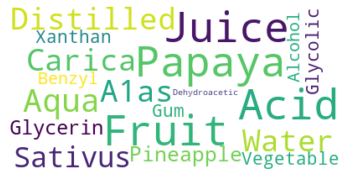

In [84]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Example of product with low hazard conern
text = data.ingredients[0]
print(text)
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Create stopword list:
stopwords = set(STOPWORDS)
# remove commen words
stopwords.update(["May", "Contain", "Extract", "Fruit", "Oil", "water", "Aqua", "Juice", "Distilled", "Vegetable", "Eau"])

# Display the generated image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("Low hazard concern products contain mostly water and natrual fruit extracts:")

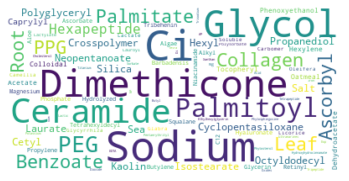

High hazard concern products contain mostly chemical substances:


In [107]:
# Example of ingredients from high hazard conern product
text2 = data.ingredients[4655]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text2)

# Display the generated image:
wordcloud = WordCloud(stopwords= stopwords, max_font_size=50, max_words=100, background_color="white").generate(text2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("High hazard concern products contain mostly chemical substances:")

In [86]:
# Get all the words in
text = " ".join(ingredient for ingredient in data.ingredients)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 3055496 words in the combination of all review.


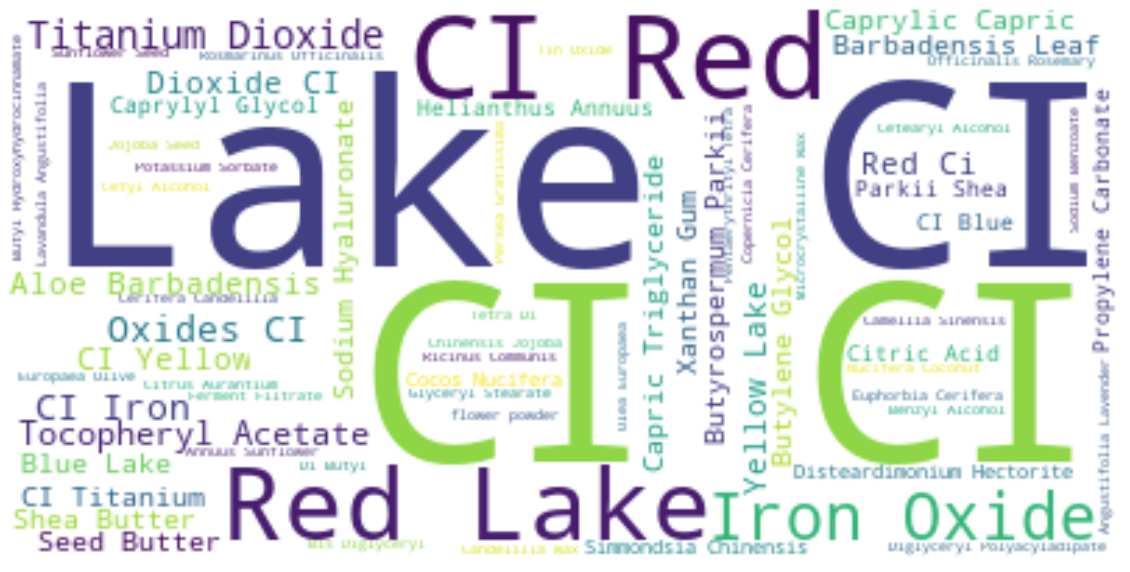

In [87]:
# Generate a word cloud image
wordcloud = WordCloud( stopwords= stopwords, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Preprocessing data**

In [108]:
# create a copy of the data: 
 df = data.loc[:, ['score', 'ingredients']]

# Grouping data into 3 categories according to hazard concern
## Data with score 1-2 have low hazard concern
## Data with score 3-6 have moderate hazard concern
## data with score 7-10 have high hazard concern

low = np.logical_or(df['score'] == 1, df['score'] == 2)
moderate = np.logical_and(df['score'] >= 3, df['score'] <= 6) 
high = np.logical_and(df['score'] >= 7, df['score'] <= 10)

# Assign score to concern level
df.loc[low, 'concern_level'] ='Low'
df.loc[moderate, 'concern_level'] = 'Moderate'
df.loc[high, 'concern_level'] = 'High'

# remove digits and % 
import re
df['ingredients'].apply(lambda s: re.sub(r'(\s?)\d+(?:\d+)?%', '', s))

# df.head()
df["concern_level"].unique()

array(['Low', 'Moderate', 'High'], dtype=object)

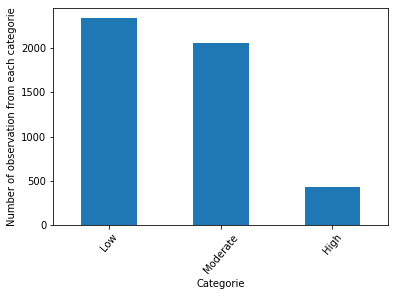

In [89]:
# Visualizing number of products from each category:
df['concern_level'].value_counts().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Categorie")
plt.ylabel("Number of observation from each categorie")
plt.show()

# **Split the data**

In [0]:
from sklearn.model_selection import train_test_split
 
X = df.ingredients
y = df.concern_level
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(X, y, test_size=0.1, random_state = 42)


# **Encode Labels**

In [91]:
from sklearn.preprocessing import LabelEncoder

# encode concern level
encoder = LabelEncoder()
encoder.fit(training_labels)

y_train = encoder.transform(training_labels)
y_test = encoder.transform(testing_labels)

# Converts a class vector (integers) to binary class matrix
num_classes = np.max(y_train) + 1

y_train = tf.keras.utils.to_categorical(y_train , num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(y_train)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


# **Tokenization & Padding**

In [114]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Hyperparameter
vocab_size = 4609
unknown_value = 'unknown'
max_length = 335

# Tokenasation
tokeniser = Tokenizer(num_words = vocab_size, oov_token = unknown_value)

# Fit on train
tokeniser.fit_on_texts(training_sentences) 
word_index = tokeniser.word_index
print('\nWord Index:')
print(word_index)

# Tokenize & padding training sentences
sequences = tokeniser.texts_to_sequences(training_sentences)
training_padded = pad_sequences(sequences, maxlen = max_length, padding='post')

print('\n\nSequences:')
print(sequences)

print('\n\nPadded Sequences:')
print(training_padded)

# Tokenize & padding testing sentences
testing_sequences = tokeniser.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)




Word Index:
{'unknown': 1, 'ci': 2, 'oil': 3, 'extract': 4, 'lake': 5, 'seed': 6, 'red': 7, 'sodium': 8, 'leaf': 9, 'flower': 10, 'acid': 11, 'alcohol': 12, 'water': 13, 'fruit': 14, 'glycol': 15, 'iron': 16, 'dimethicone': 17, '1': 18, 'wax': 19, 'titanium': 20, 'glycerin': 21, 'dioxide': 22, 'oxides': 23, 'silica': 24, 'powder': 25, 'root': 26, '15850': 27, 'acetate': 28, '77491': 29, '77891': 30, 'organic': 31, 'butter': 32, '77499': 33, '77492': 34, '2': 35, 'hydrogenated': 36, 'tocopheryl': 37, 'may': 38, 'contain': 39, 'phenoxyethanol': 40, 'officinalis': 41, 'yellow': 42, 'aloe': 43, '7': 44, '5': 45, 'citrus': 46, '6': 47, 'mica': 48, 'tocopherol': 49, 'aqua': 50, '45410': 51, 'gum': 52, 'stearate': 53, 'barbadensis': 54, 'glyceryl': 55, 'palmitate': 56, 'oxide': 57, '42090': 58, 'capric': 59, 'caprylic': 60, 'triglyceride': 61, 'peg': 62, 'copolymer': 63, 'fragrance': 64, 'propylene': 65, 'hectorite': 66, 'cerifera': 67, 'cetyl': 68, 'aluminum': 69, 'ethylhexylglycerin': 70, 

In [115]:
# Printing training and testing sets shapes
print('train_ingredients shape:', training_padded.shape)
print('test_ingredients shape:', testing_padded.shape)
print('train_labesls shape:', y_train.shape )
print('train_labesls shape:', y_test.shape)

train_ingredients shape: (4347, 335)
test_ingredients shape: (484, 335)
train_labesls shape: (4347, 3)
train_labesls shape: (484, 3)


# **Build Create the model**


In [0]:
embedding_dim = 50

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim= vocab_size, output_dim = embedding_dim ),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(3, activation = 'softmax')
])


# **Compile Model**

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# **Train Model**

In [96]:
num_epochs = 5

history = model.fit(training_padded, 
          y_train,
          epochs= num_epochs, 
          validation_data=(testing_padded, y_test))

Train on 4347 samples, validate on 484 samples
Epoch 1/5
4347/4347 [==============================] - 2s 524us/sample - loss: 0.7753 - acc: 0.7203 - val_loss: 0.4409 - val_acc: 0.8450
Epoch 2/5
4347/4347 [==============================] - 2s 368us/sample - loss: 0.3415 - acc: 0.8654 - val_loss: 0.2247 - val_acc: 0.9256
Epoch 3/5
4347/4347 [==============================] - 2s 365us/sample - loss: 0.1683 - acc: 0.9402 - val_loss: 0.1430 - val_acc: 0.9483
Epoch 4/5
4347/4347 [==============================] - 2s 377us/sample - loss: 0.0976 - acc: 0.9671 - val_loss: 0.1140 - val_acc: 0.9587
Epoch 5/5
4347/4347 [==============================] - 2s 375us/sample - loss: 0.0616 - acc: 0.9818 - val_loss: 0.0994 - val_acc: 0.9628


# **Plot accuracy**

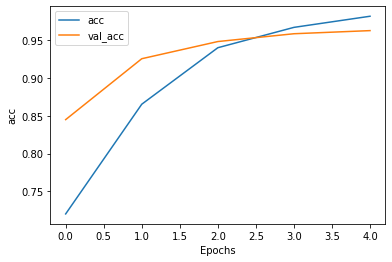

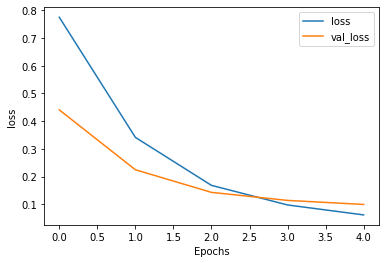

In [97]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

# **Evaluate Model**

In [98]:
# Model accuracy
score = model.evaluate(testing_padded, y_test, verbose=1)
print('Test accuracy:', score[1])

484/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# **Predictions**

In [99]:
# Predict on new text
text1 = ["Aqua, Aloe barbadensis leaf extract, Glycerin, Butylene glycol, Caprylic/capric triglyceride, Arachidyl alcohol, Behenyl alcohol, Arachidyl glucoside, Zanthoxylum piperitum fruit extract, Usnea barbata (lichen) extract, Pulsatilla koreana extract, Betaine, Verbena officinalis extract, Rosmarinus officinalis leaf extract, Chamomilla recutita flower extract, Propanediol, Ethylhexylglycerin, Xanthan gum, Allantoin, Bifida ferment filtrate, Lactobacillus/olea europaea leaf fement extract, 1,2-Hexanediol, Coco-caprylate/caprate, Hydrogenated olive oil unsaponifiables, Hydrolyzed glycosaminoglycans, Pancratium maritimum extract, Phenethyl alcohol, Adenosine, Tamarindus indica seed polysaccharide, Ceramide NP, Helianthus annuus seed oil, Prunus armeniaca kernel oil, Tocopherol, Olus oil"]

def prepare(text):
  tokenized = tokeniser.texts_to_sequences(text)
  padded = pad_sequences(tokenized , maxlen = max_length)
  return padded

model.predict_classes(prepare(text1))

array([1])

# **Save Model**

In [0]:
# Save model as h5
def export_model(model):
  model.save('tf_model.h5') 

export_model(model)

# **Export Tokenizer**

In [0]:
# Export Tokenizer
def export_tokeniser(tk):
  # saving
  with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
export_tokeniser(tokeniser)